In [2]:
import cv2
import numpy as np

import PIL
import matplotlib.pyplot as plt

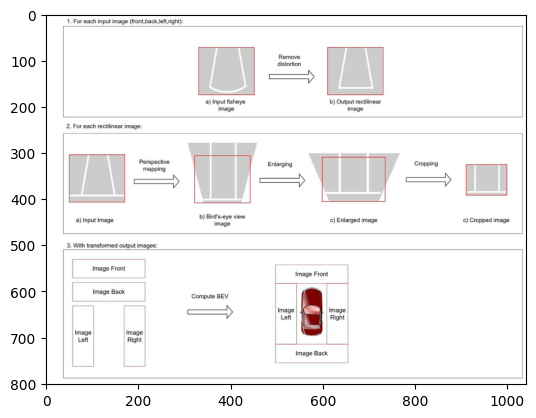

(<matplotlib.image.AxesImage at 0x1ec003eb1c0>, None)

In [3]:
exec_path_img = cv2.imread('../data/fisheye/bev_path.png')
plt.imshow(exec_path_img), plt.show()

In [4]:
# K: !!opencv-matrix
#    rows: 3
#    cols: 3
#    dt: d
#    data: [ 659.9565405462982, -2.8848508379788056, 634.6329612029243, 0.0, 625.1032520893773, 544.7433055928482, 0., 0., 1. ]
# D: !!opencv-matrix
#    rows: 1
#    cols: 4
#    dt: d
#    data: [ -0.2900269437421997, 0.11089496468175668, -0.0003222479159157141, 0.0029110573007121382]
# xi: !!opencv-matrix
#    rows: 1
#    cols: 1
#    dt: d
#    data: [ 1.0866311153248236 ]
# board_width: 9
# board_height: 6
# square_size: 2.4229999631643295e-02

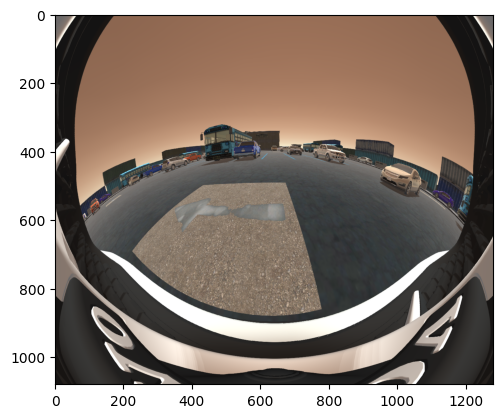

(<matplotlib.image.AxesImage at 0x1ec02b7c8b0>, None)

In [5]:
image1 = cv2.imread('../data/fisheye/left_851.png')
image2 = cv2.imread('../data/fisheye/front_851.png')
image3 = cv2.imread('../data/fisheye/right_851.png')
image4 = cv2.imread('../data/fisheye/rear_851.png')

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
gray4 = cv2.cvtColor(image4, cv2.COLOR_BGR2GRAY)

plt.imshow(image2), plt.show()

In [6]:
# Camera matrix (intrinsic parameters)
K_data = [-659.9565405462982, 2.8848508379788056, 634.6329612029243, 0.0, 625.1032520893773, 544.7433055928482, 0., 0., 1.]
K = np.array(K_data).reshape(3, 3)

# Distortion coefficients
D_data = [-0.2900269437421997, 0.11089496468175668, -0.0003222479159157141 , 0.0029110573007121382]
D = np.array(D_data).reshape(1, 4)

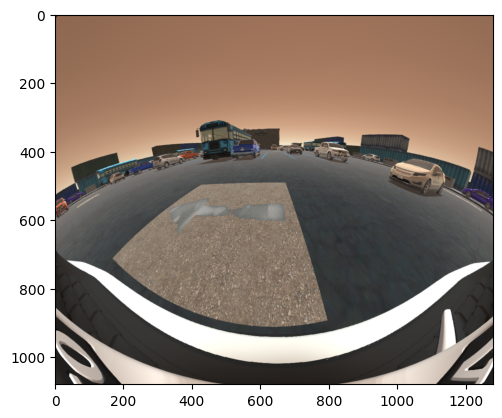

(<matplotlib.image.AxesImage at 0x1ec02ba5990>, None)

In [7]:
rectilinear_img =  cv2.undistort(image1, K, D)  # LEFT
rectilinear_img2 = cv2.undistort(image2, K, D) # FRONT
rectilinear_img3 = cv2.undistort(image3, K, D) # RIGHT
rectilinear_img4 = cv2.undistort(image4, K, D) # REAR

# plt.imshow(rectilinear_img), plt.show()
plt.imshow(rectilinear_img2), plt.show()

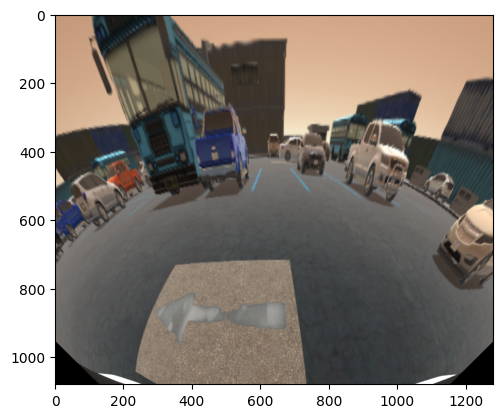

(<matplotlib.image.AxesImage at 0x1ec05b5c5b0>, None)

In [8]:
height, width = image2.shape[:2]
tilt = 0.3
b_tilt = 0.3

src_pts1 = np.array([[width * tilt, height * tilt], 
                     [width * (1 - tilt), height * tilt], 
                     [0, height - (height * b_tilt)], 
                     [width, height  - (height * b_tilt)]], dtype=np.float32)

dst_pts = np.array([[0, 0], [width, 0], [0, height], [width, height]], dtype=np.float32)

M1 = cv2.getPerspectiveTransform(src_pts1, dst_pts)

warped_image1 = cv2.warpPerspective(rectilinear_img, M1, (width, height))
warped_image2 = cv2.warpPerspective(rectilinear_img2, M1, (width, height))
warped_image3 = cv2.warpPerspective(rectilinear_img3, M1, (width, height))
warped_image4 = cv2.warpPerspective(rectilinear_img4, M1, (width, height))


# plt.imshow(warped_image1), plt.show() # LEFT 
plt.imshow(warped_image2), plt.show() # FRONT
# plt.imshow(warped_image3), plt.show() # RIGHT
# plt.imshow(warped_image4), plt.show() # REAR


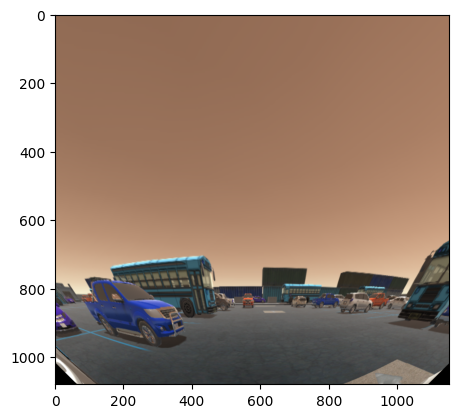

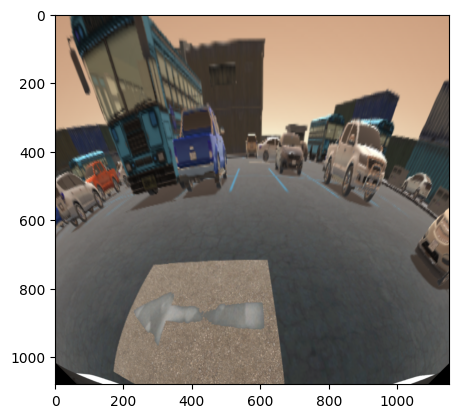

(<matplotlib.image.AxesImage at 0x1ec05c39f60>, None)

In [9]:

# Define the coordinates of the region you want to crop (x, y, width, height)
new_height, new_width = image2.shape[:2]
x_factor = new_width
crop = 0.05
new_width = new_width - (int(new_width*crop))
x, y = int(x_factor*crop), 0


# Crop the region of interest from the image
cropped_image1 = warped_image1[y:y+new_height, x:new_width]
cropped_image2 = warped_image2[y:y+new_height, x:new_width]
cropped_image3 = warped_image3[y:y+new_height, x:new_width]
cropped_image4 = warped_image4[y:y+new_height, x:new_width]

plt.imshow(cropped_image1), plt.show()
plt.imshow(cropped_image2), plt.show()
# plt.imshow(cropped_image3), plt.show()
# plt.imshow(cropped_image4), plt.show()

In [15]:
def place_and_rotate_image(image, degrees, x, y):
    # Get the dimensions of the input image
    h, w = image.shape[:2]

    # Create a new canvas twice the size of the input image
    canvas_size = (int(1.6 * w), int(1.6 * h))
    canvas = np.zeros((canvas_size[1], canvas_size[0], 3), dtype=np.uint8)

    # Calculate the center of the new canvas
    center_x, center_y = canvas_size[0] // 2, canvas_size[1] // 2

    # Calculate the top-left position for placing the image based on the given translation (x, y)
    top_left_x = center_x - w // 2 + x
    top_left_y = center_y - h // 2 + y

    # Calculate the range of pixels to copy from the source image
    src_x1 = max(0, -top_left_x)
    src_y1 = max(0, -top_left_y)
    src_x2 = min(w, canvas_size[0] - top_left_x)
    src_y2 = min(h, canvas_size[1] - top_left_y)

    # Calculate the destination top-left corner on the canvas
    dst_x1 = max(0, top_left_x)
    dst_y1 = max(0, top_left_y)
    dst_x2 = dst_x1 + (src_x2 - src_x1)
    dst_y2 = dst_y1 + (src_y2 - src_y1)

    # Copy the image region to the canvas
    if src_x2 > src_x1 and src_y2 > src_y1:
        canvas[dst_y1:dst_y2, dst_x1:dst_x2] = image[src_y1:src_y2, src_x1:src_x2]

    # Define the rotation matrix around the original center
    M = cv2.getRotationMatrix2D((center_x, center_y), degrees, 1)

    # Perform the rotation
    rotated_canvas = cv2.warpAffine(canvas, M, canvas_size)

    return rotated_canvas

def overlay_images(image1, image2, alpha=.50):
    if not (0 <= alpha <= 1):
        raise ValueError("Alpha should be a float between 0 and 1.")
    
    # Calculate beta (the weight of the second image)
    beta = 1.0 - alpha
    
    blended_image = cv2.addWeighted(image1, alpha, image2, beta, 0)
    return blended_image

In [16]:

left = place_and_rotate_image(cropped_image1, 90, 0, -960)
right = place_and_rotate_image(cropped_image3, -90, 0, -960)
front = place_and_rotate_image(cropped_image2, 0, 0, -810)
rear = place_and_rotate_image(cropped_image4, 180, 0, -810)

(<matplotlib.image.AxesImage at 0x1ec0d261720>,
 <function matplotlib.pyplot.show(close=None, block=None)>)

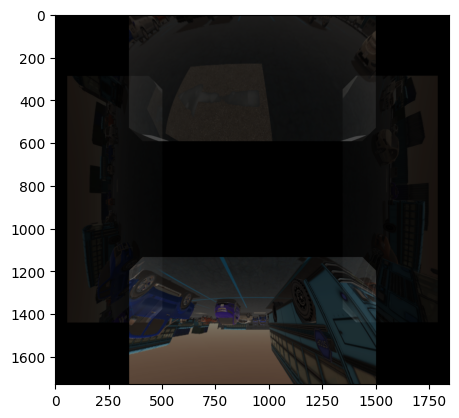

In [17]:
LR = overlay_images(left, right)
FLR = overlay_images(front, LR)
FLRR = overlay_images(rear, FLR)
plt.imshow(FLRR), plt.show